# EDC T in AICC2023, T from Jouzel et al., 2007, data from Thomas

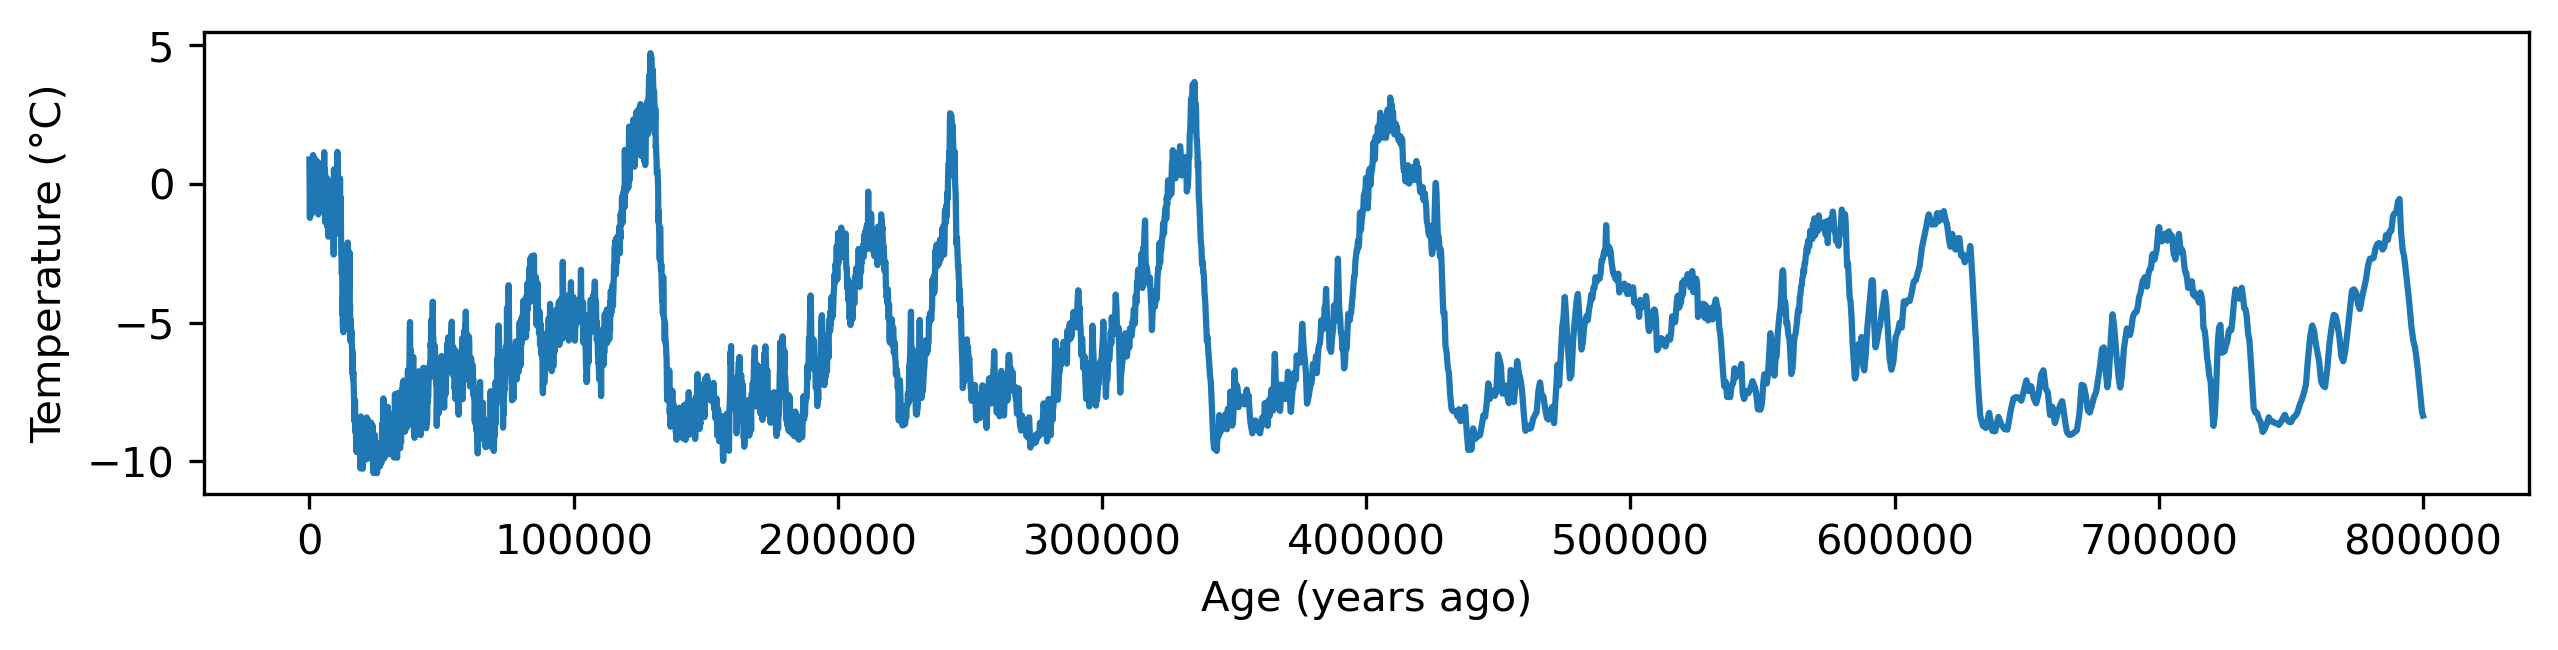

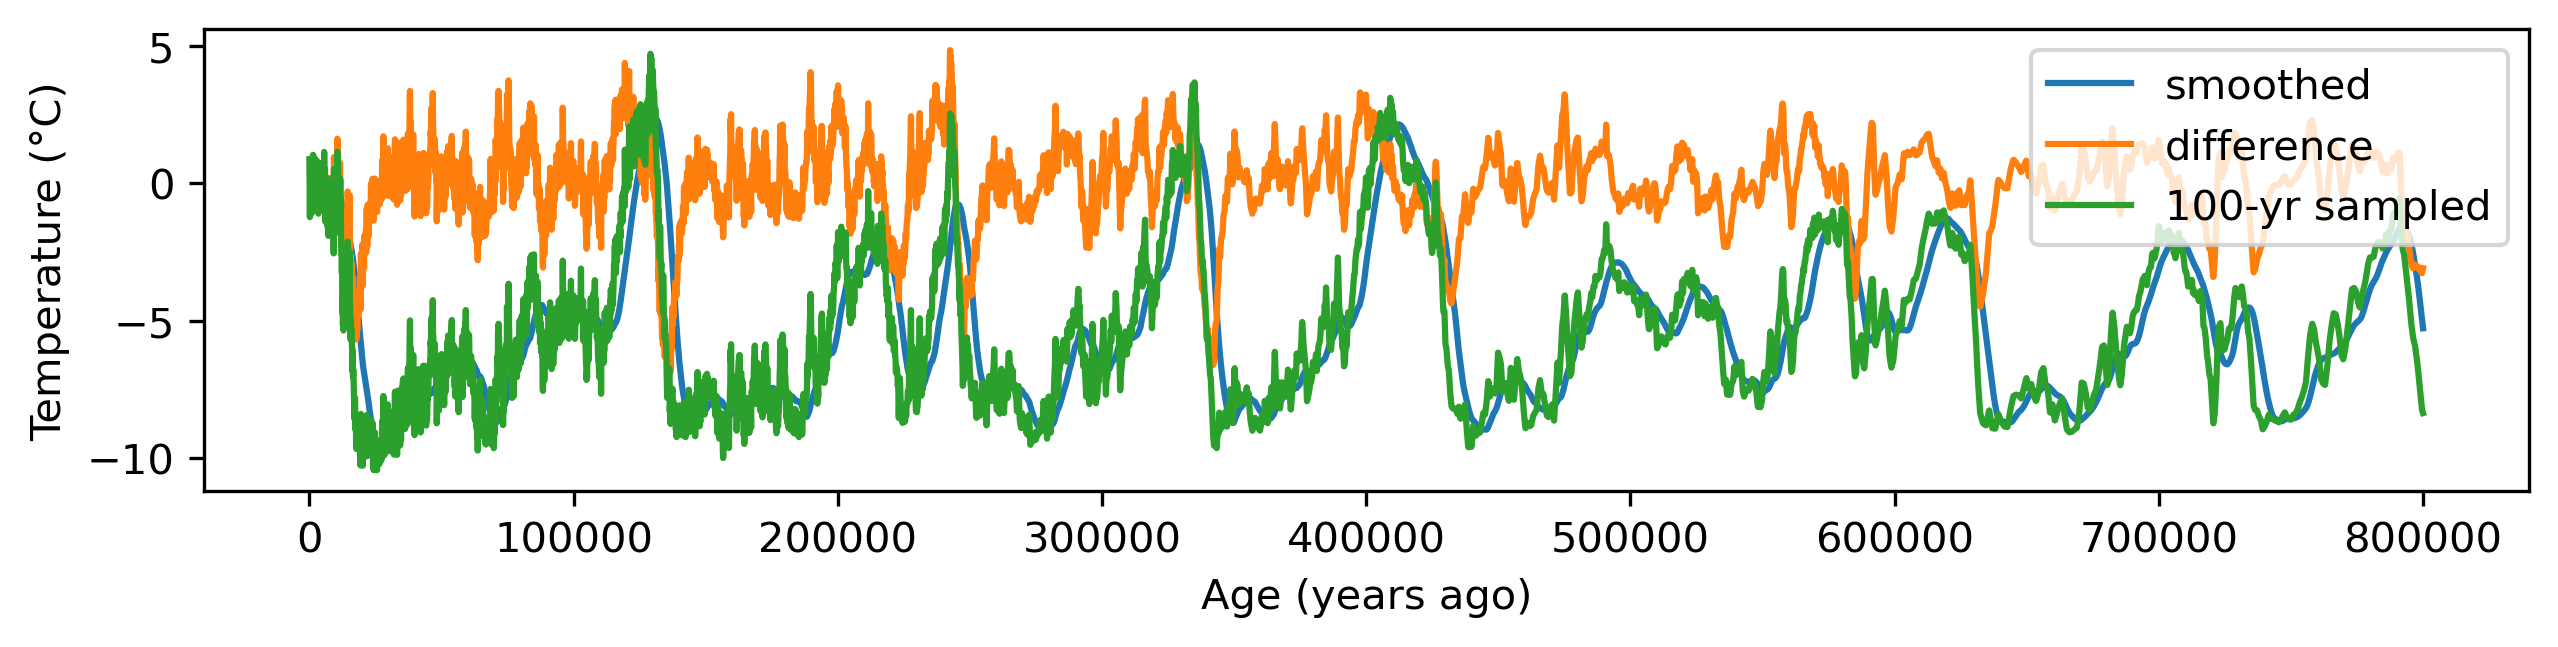

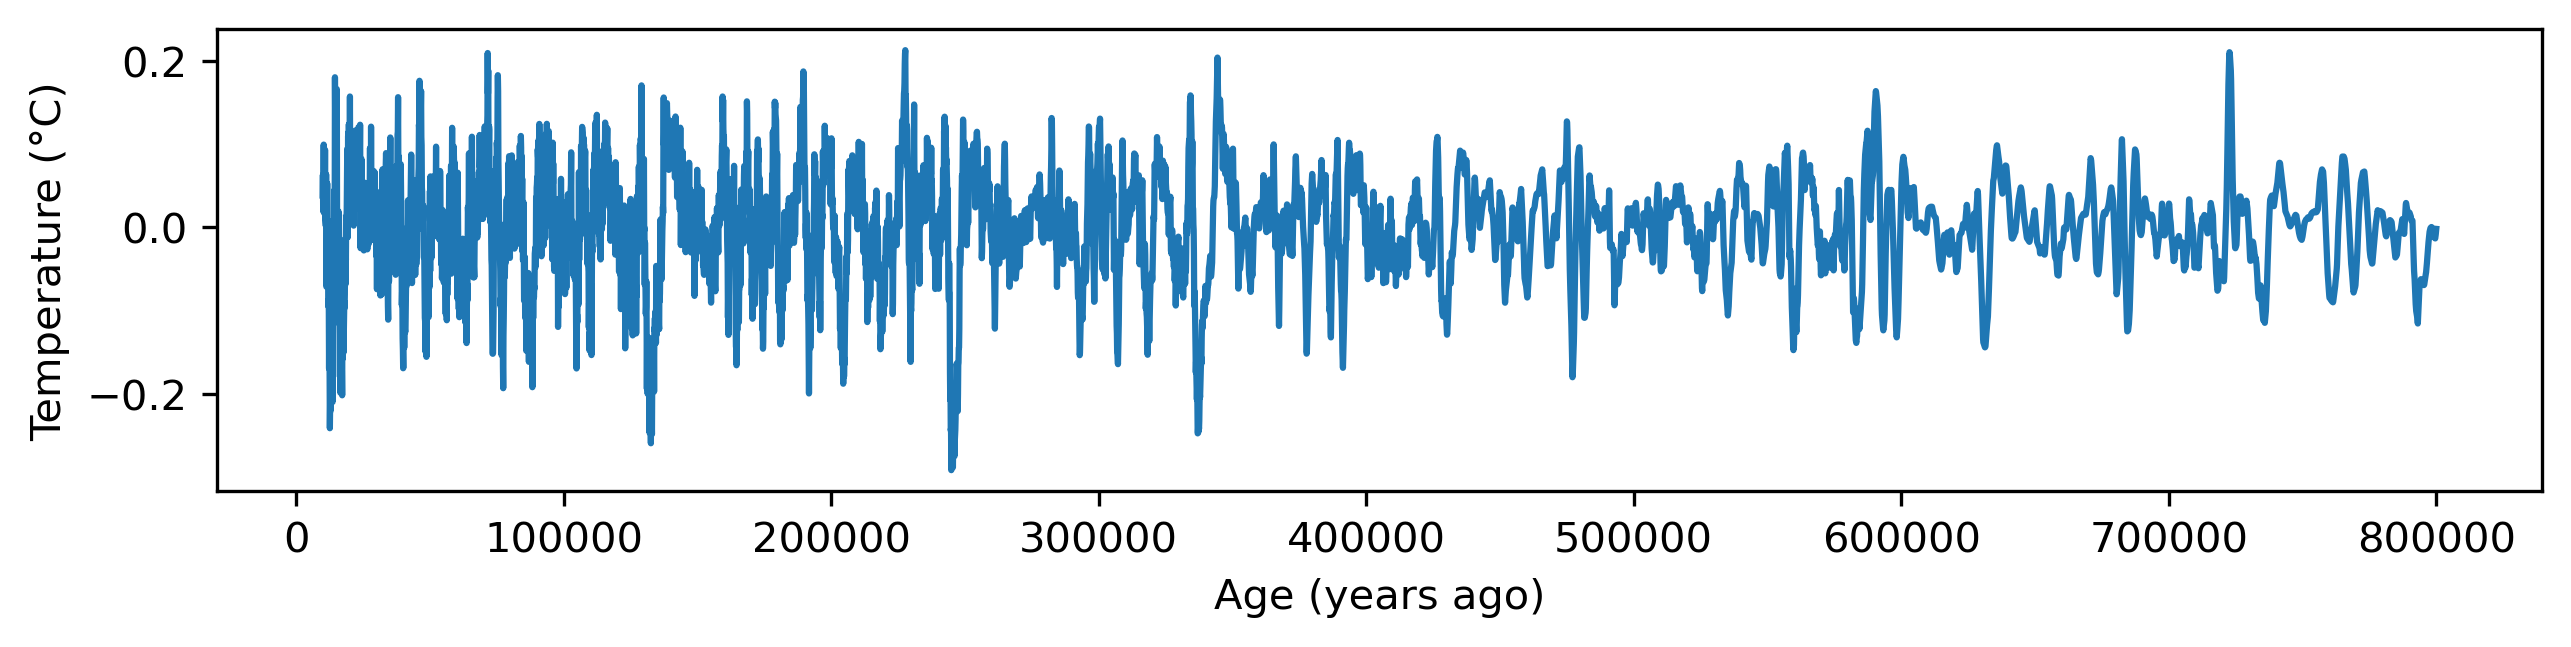

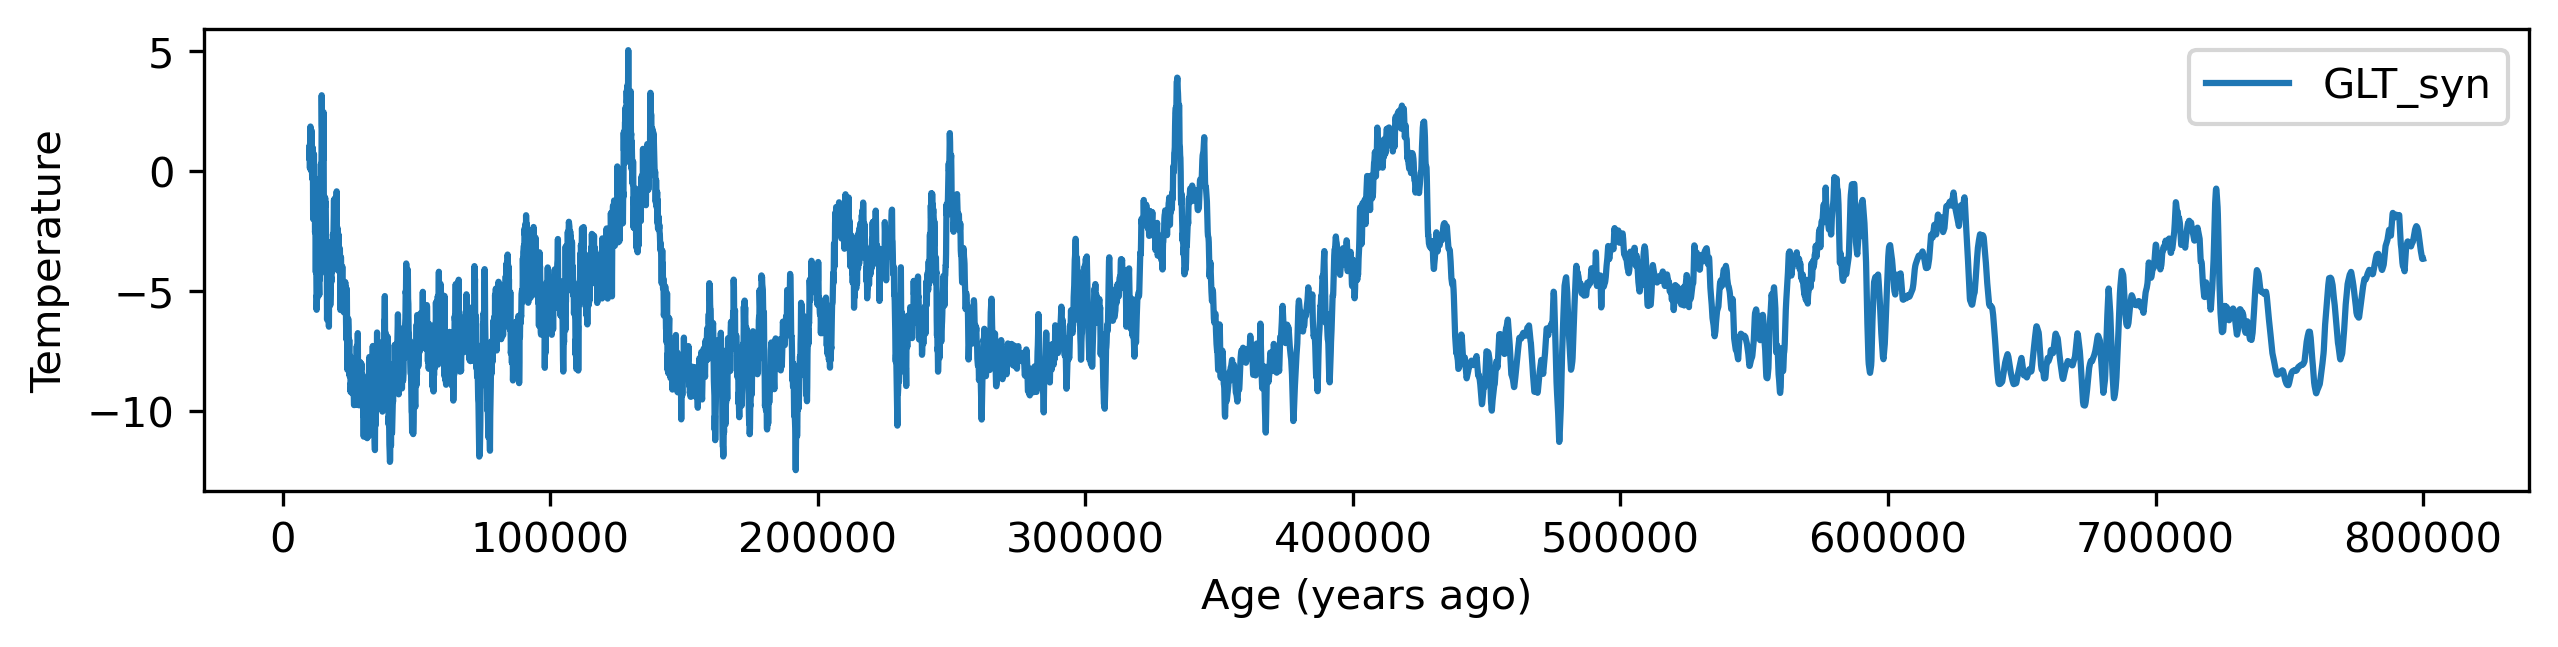

In [122]:
import pandas as pd
import numpy as np

df = pd.read_excel('other_data/EDC_temp_Thomas.xlsx', sheet_name='Sheet1')
# drop nan
df = df.dropna()

# rename columns 'age' and temprature
df = df.rename(columns={'age': 'age', 'AT': 'temperature'})

df_new = pd.DataFrame()
df_new['age'] = np.arange(0, 800001, 100)
df_new['temperature'] = np.interp(df_new['age'], df['age'], df['temperature'])

# plot the data
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 2), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(df_new['age'], df_new['temperature'])
plt.xlabel('Age (years ago)')
plt.ylabel('Temperature (°C)')
plt.show()

df_new


# smooth the data using a moving average filter with a window size of 7000 years
df_new['temperature_smoothed'] = df_new['temperature'].rolling(window=80).mean()
# calculate the difference between the smoothed and the original data
df_new['temperature_diff'] = df_new['temperature'] - df_new['temperature_smoothed']
# plot the 100-yr sampled, smoothed and difference data
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 2), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(df_new['age'], df_new['temperature_smoothed'], label='smoothed')
plt.plot(df_new['age'], df_new['temperature_diff'], label='difference')
plt.plot(df_new['age'], df_new['temperature'], label='100-yr sampled')
plt.xlabel('Age (years ago)')
plt.ylabel('Temperature (°C)')
plt.legend()


# calculate the derivative of the temperature difference
df_new['temperature_diff_derivative'] = df_new['temperature_diff'].diff()
# smooth the derivative using a moving average filter
df_new['temperature_diff_derivative'] = df_new['temperature_diff_derivative'].rolling(window=20).mean()
# plot the derivative
fig=plt.figure(figsize=(10, 2), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(df_new['age'], df_new['temperature_diff_derivative'])
plt.xlabel('Age (years ago)')
plt.ylabel('Temperature (°C)')
plt.show()

''' 
create a new column called 'GLT_syn' equals to the derivative of the EDC temperature difference plus
the smoothed EDC temperature that 2000 years before the current time step
'''
df_new['GLT_syn'] = df_new['temperature_diff_derivative']*22 + df_new['temperature_smoothed'].shift(20)
# add a new column to store the shifted smoothed EDC temperature
df_new['temperature_smoothed_shifted'] = df_new['temperature_smoothed'].shift(20)
df_new

# plot the synthetic Greenland temperature
fig=plt.figure(figsize=(10, 2), dpi= 300, facecolor='w', edgecolor='k')
plt.plot(df_new['age'], df_new['GLT_syn'], label='GLT_syn')
#plt.plot(df_GT_new['age'], df_GT_new['d18o'], label='GLT')
plt.xlabel('Age (years ago)')
plt.ylabel('Temperature')
plt.legend()


→ optimal window=3290, threshold lt 0.680, max F1=0.678


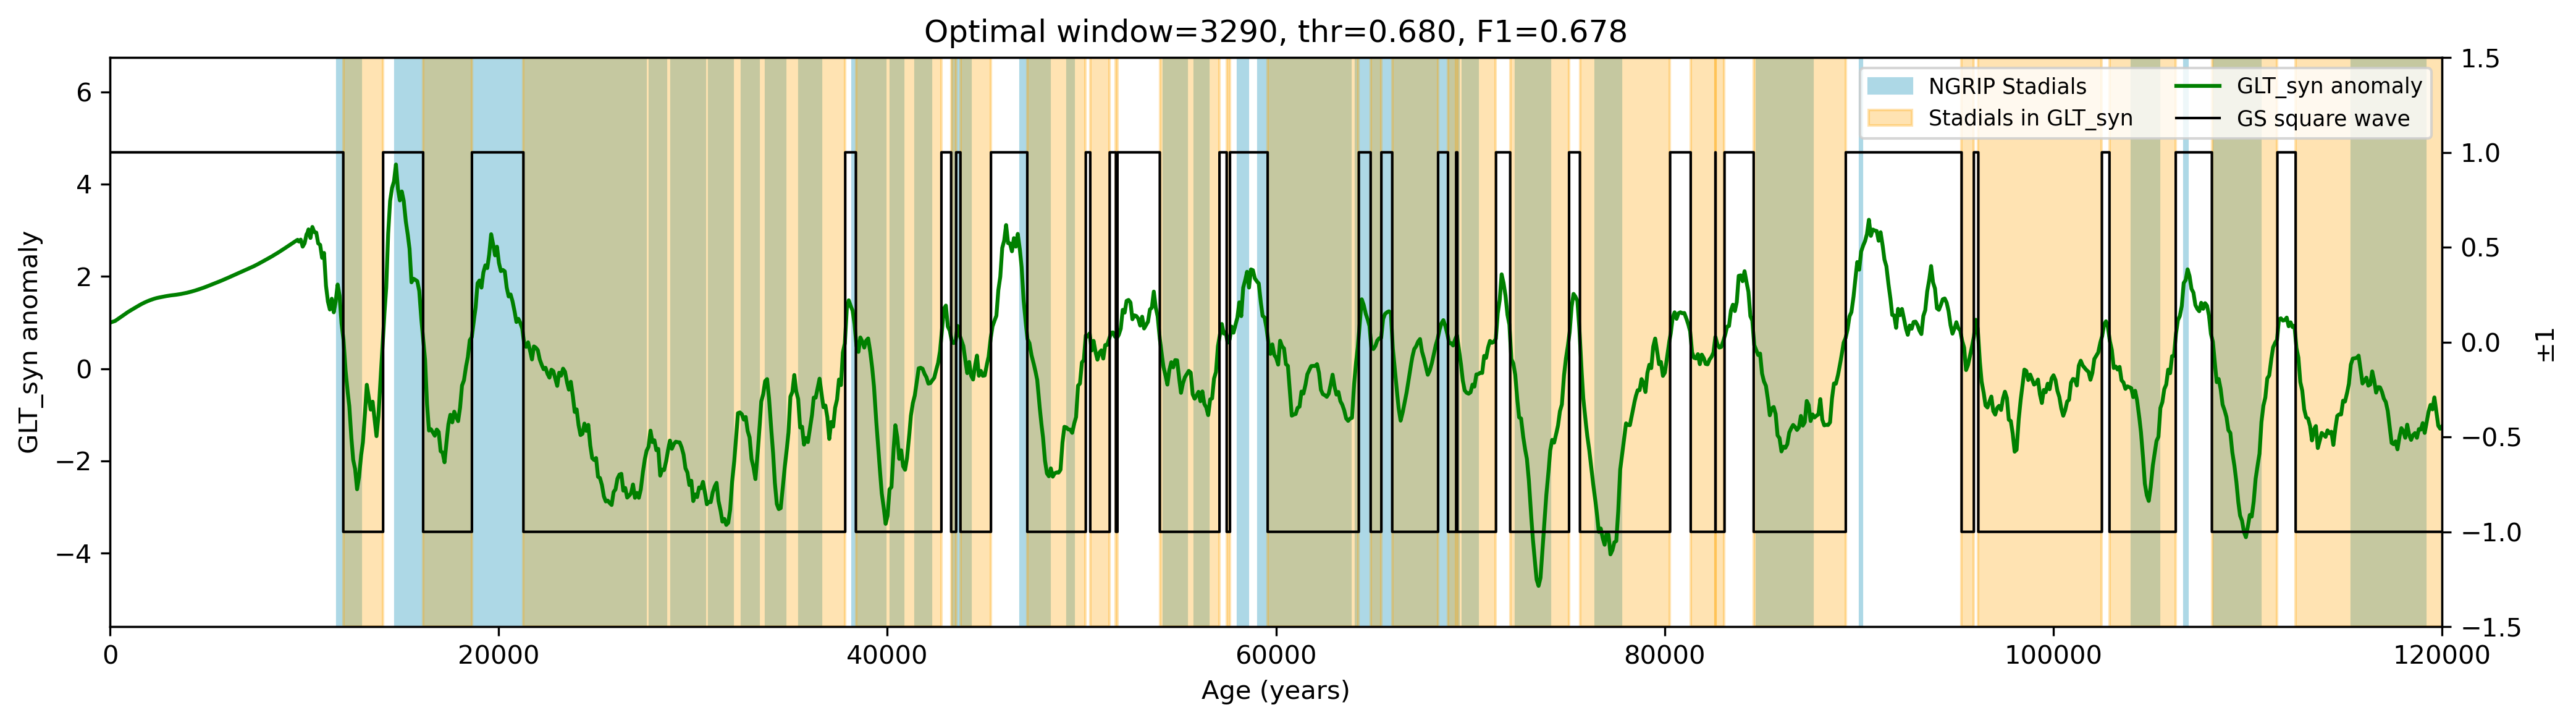

In [125]:


from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)
import pandas as pd

df=df_new

# only keep the columns 'age' and 'GLT_syn'
df = df[['age', 'GLT_syn']]
# drop rows with NaN values
df = df.dropna()
new_df, df_sq, best = sa.build_DO_sq(df, if_plot=True, age_start=0, age_end=799630, extra_sm=50, dir='lt',diff=False)


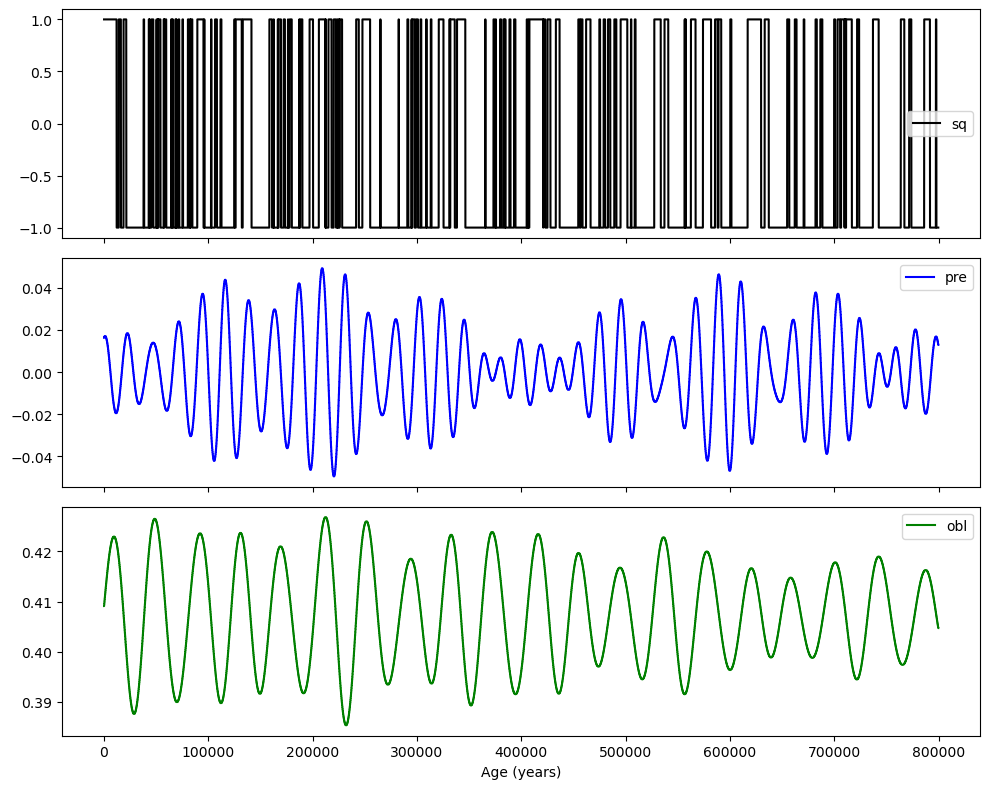

          age   sq
0           0  1.0
1          10  1.0
2          20  1.0
3          30  1.0
4          40  1.0
...       ...  ...
79958  799580 -1.0
79959  799590 -1.0
79960  799600 -1.0
79961  799610 -1.0
79962  799620 -1.0

[79963 rows x 2 columns]
          age      pre
0           0  0.01628
1          10  0.01628
2          20  0.01628
3          30  0.01628
4          40  0.01628
...       ...      ...
79958  799580  0.01288
79959  799590  0.01288
79960  799600  0.01288
79961  799610  0.01288
79962  799620  0.01288

[79963 rows x 2 columns]
Length of df_sq_rs: 79963


In [126]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq, df_pre, df_obl = sa.interpolate_data_forcing(df_sq, 10, if_plot=True)
print(df_sq)
print(df_pre)
# print the length of df_sq_rs and df_pre_rs
print('Length of df_sq_rs:', len(df_sq))

TE(pre→residual) = 0.0002 bits


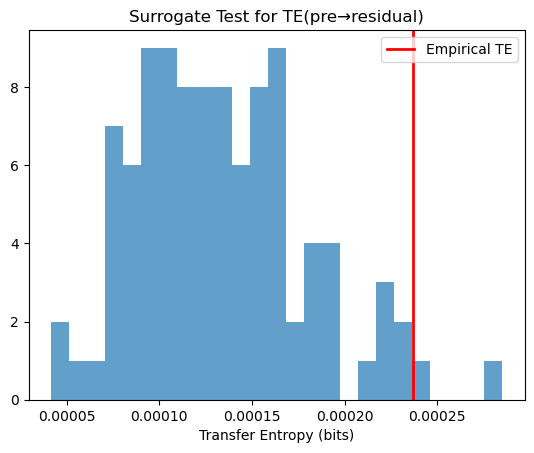

p-value = 0.020


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy  # correct import! :contentReference[oaicite:0]{index=0}

# — assume df_pre_aligned['pre'] and df_residual['residual'] exist and are same length
x = df_pre['pre'].values      # source (precession)
y = df_sq['sq'].values    # target (residual)

# flip x and y upside down
x = x[::-1]
y = y[::-1]

# 1) Discretize into nbins equiprobable bins
nbins = 8
xbins = np.histogram_bin_edges(x, bins=nbins)
ybins = np.histogram_bin_edges(y, bins=nbins)
x_disc = np.digitize(x, xbins) - 1
y_disc = np.digitize(y, ybins) - 1

# 2) Compute TE from pre→residual with history length k=1
#    note: drop last/first sample to align t→t+1
te_xy = transfer_entropy(x_disc[:-1], y_disc[1:], k=1)
print(f"TE(pre→residual) = {te_xy:.4f} bits")

# 3) Permutation‐based surrogate test
n_surr = 100
te_null = np.zeros(n_surr)
for i in range(n_surr):
    xs = np.random.permutation(x_disc)
    te_null[i] = transfer_entropy(xs[:-1], y_disc[1:], k=1)

# 4) Plot null distribution
plt.hist(te_null, bins=25, alpha=0.7)
plt.axvline(te_xy, color='r', lw=2, label='Empirical TE')
plt.xlabel('Transfer Entropy (bits)')
plt.legend()
plt.title('Surrogate Test for TE(pre→residual)')
plt.show()

# 5) Compute p-value
p_value = np.mean(te_null >= te_xy)
print(f"p-value = {p_value:.3f}")

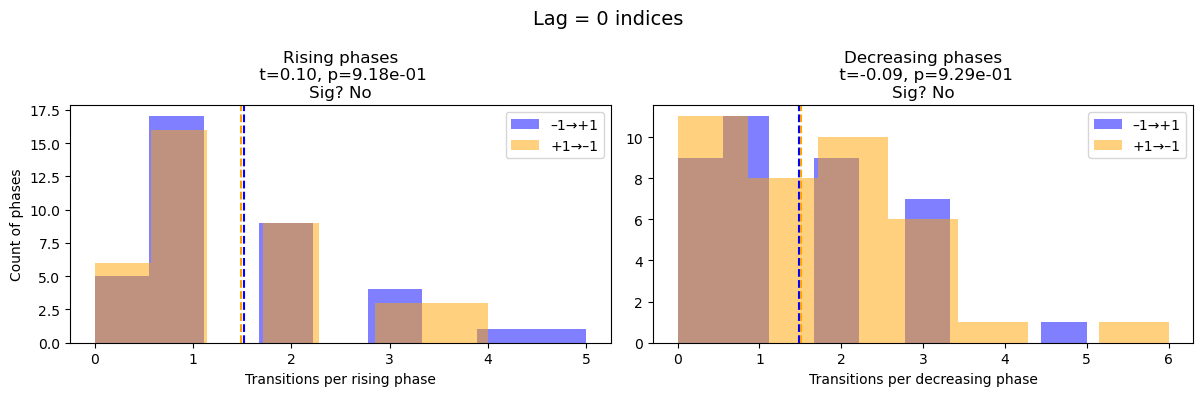

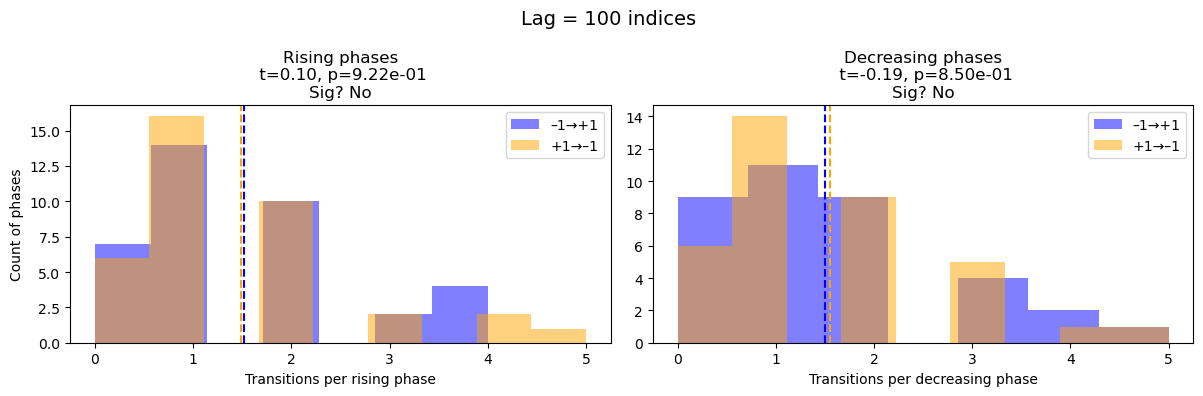

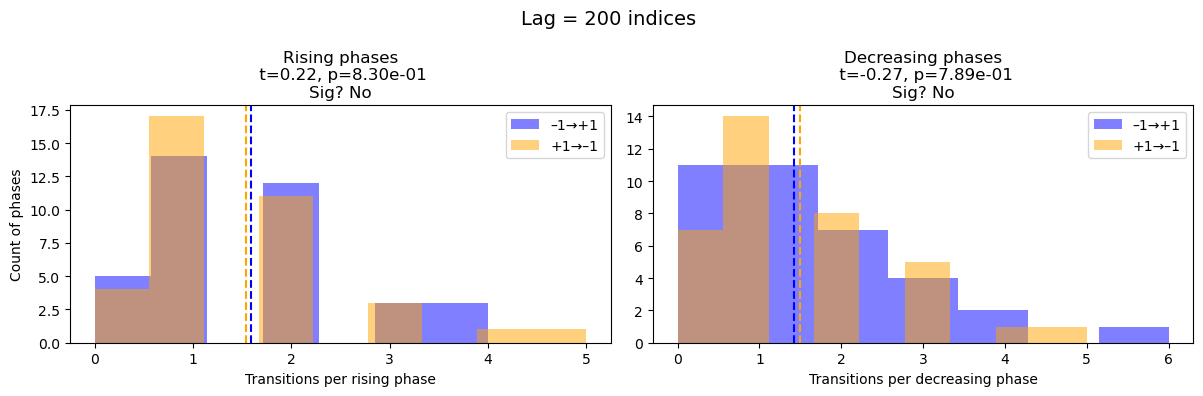

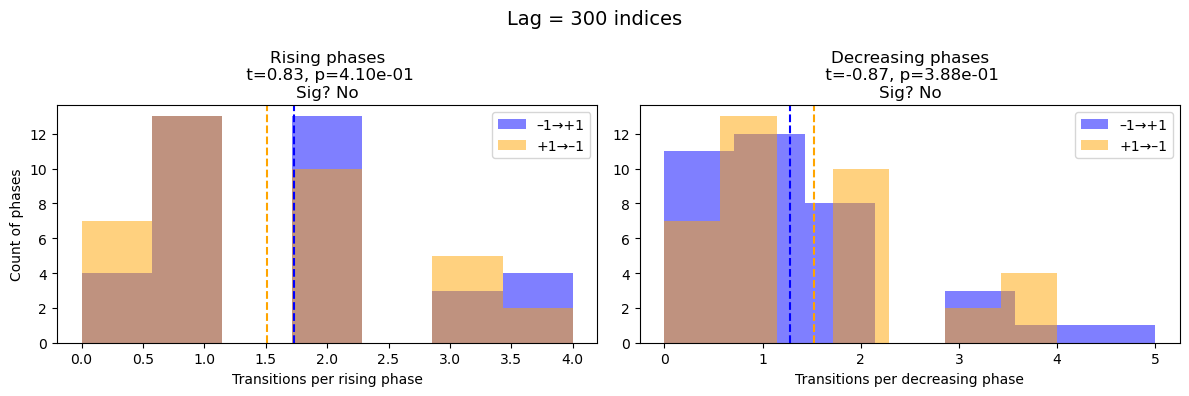

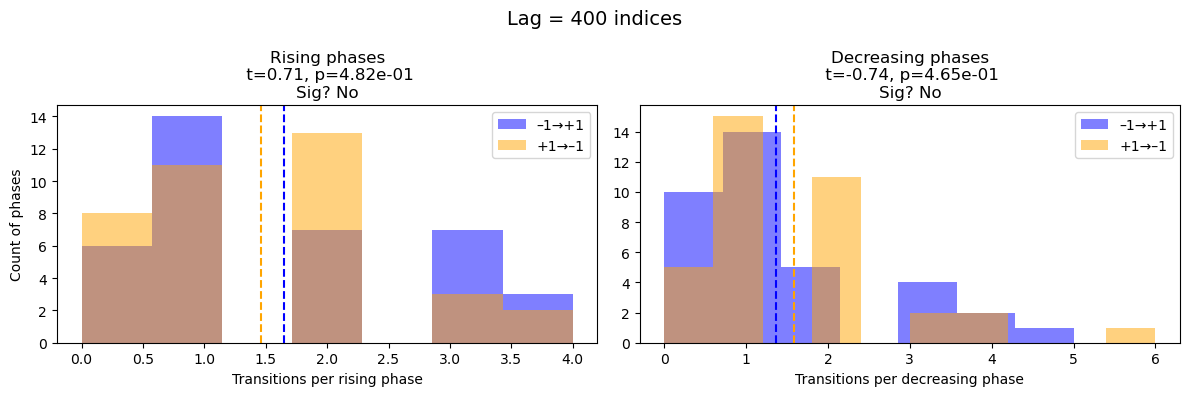

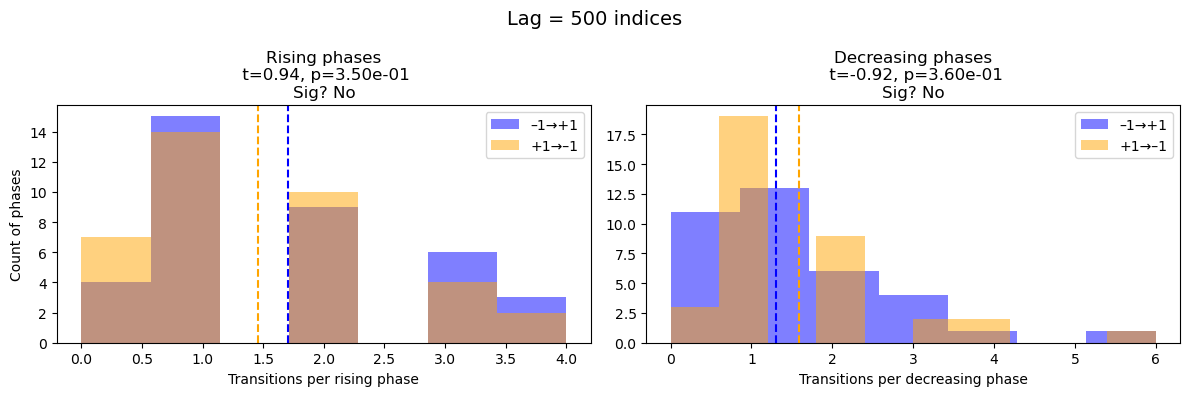

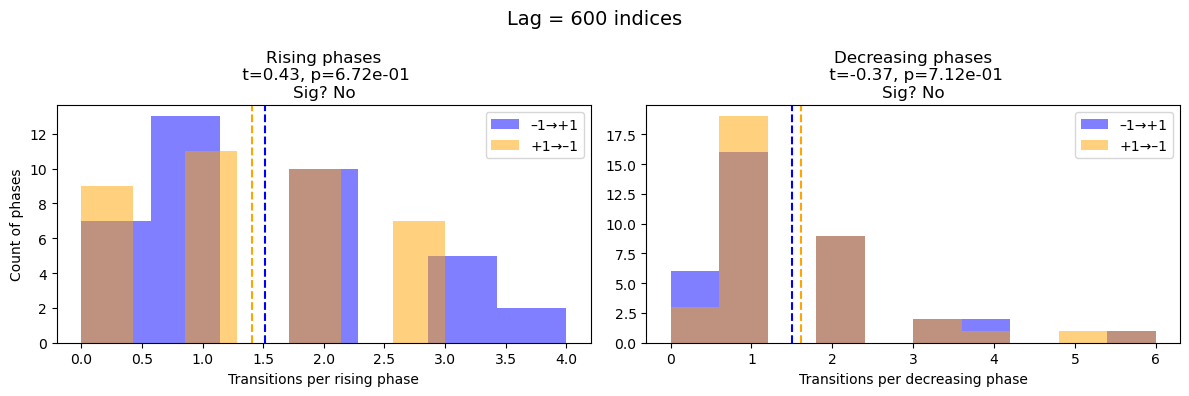

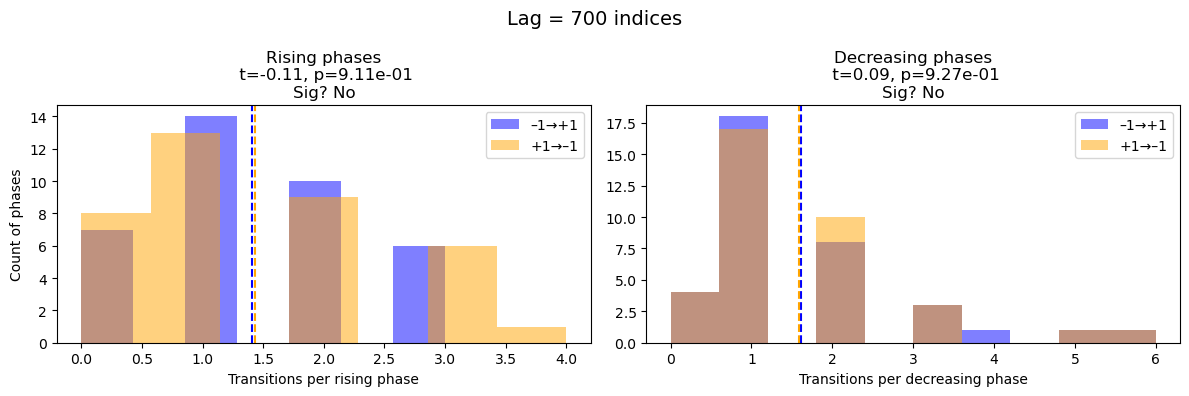

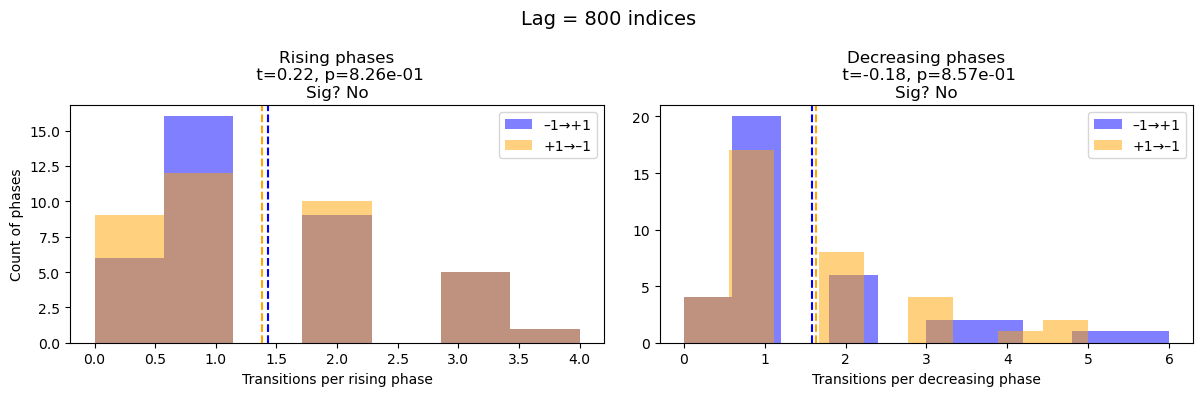

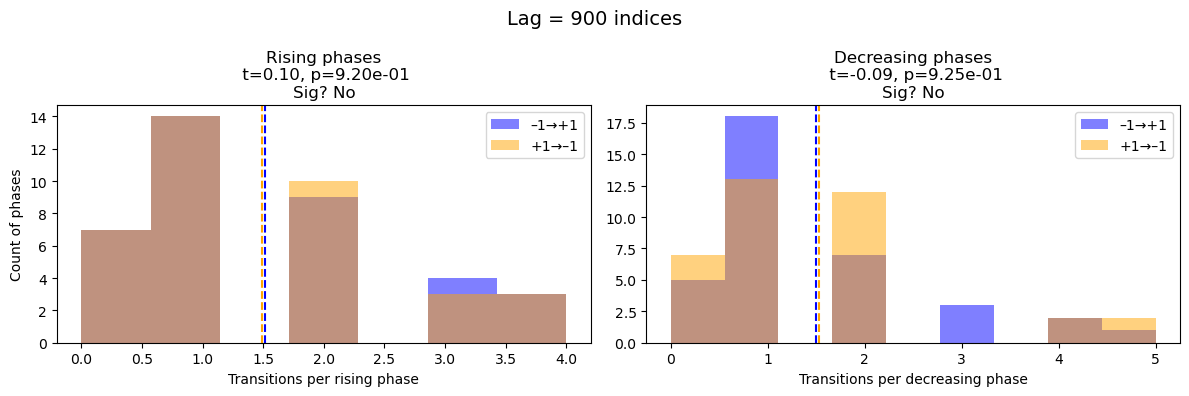

In [128]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_transition_distribution(df_pre, df_sq)

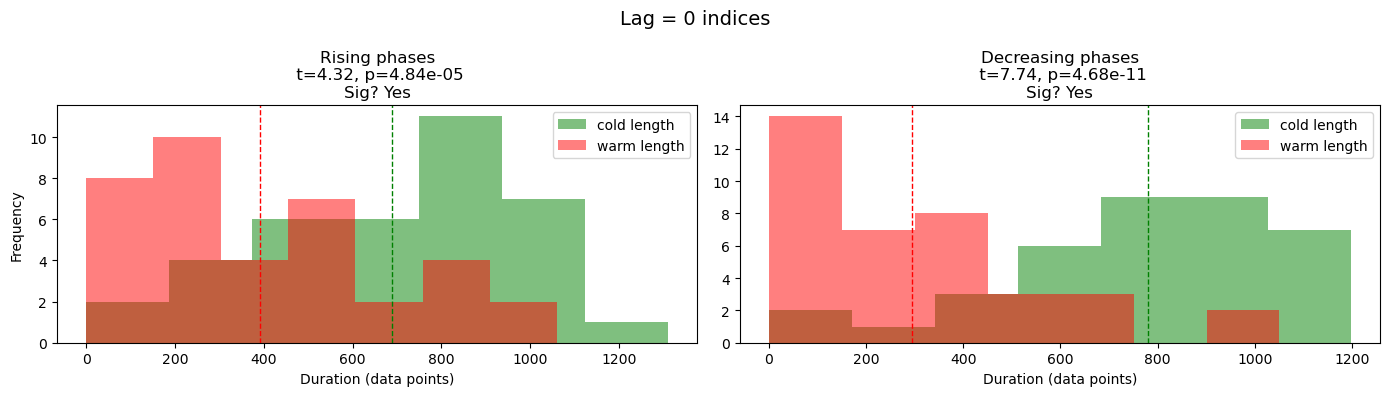

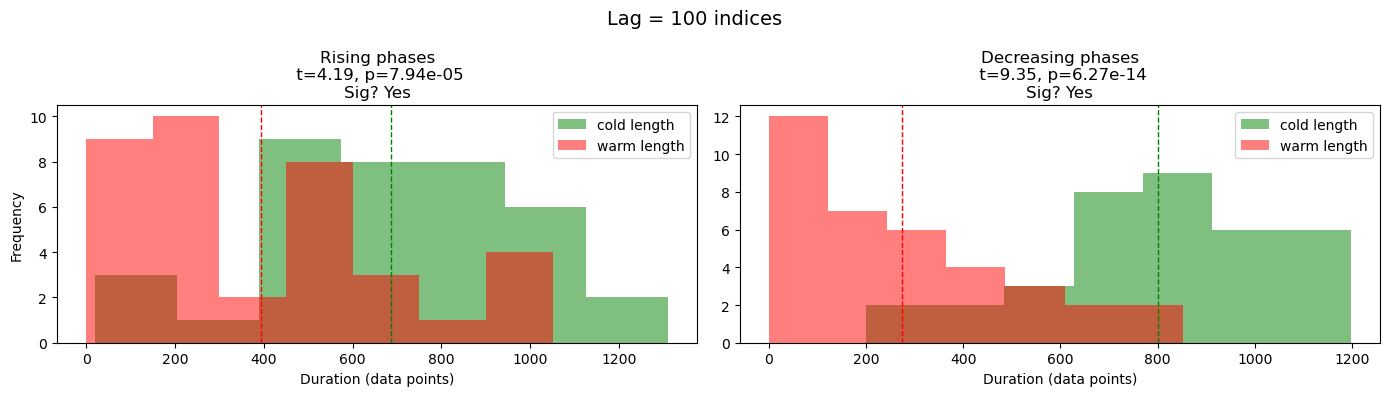

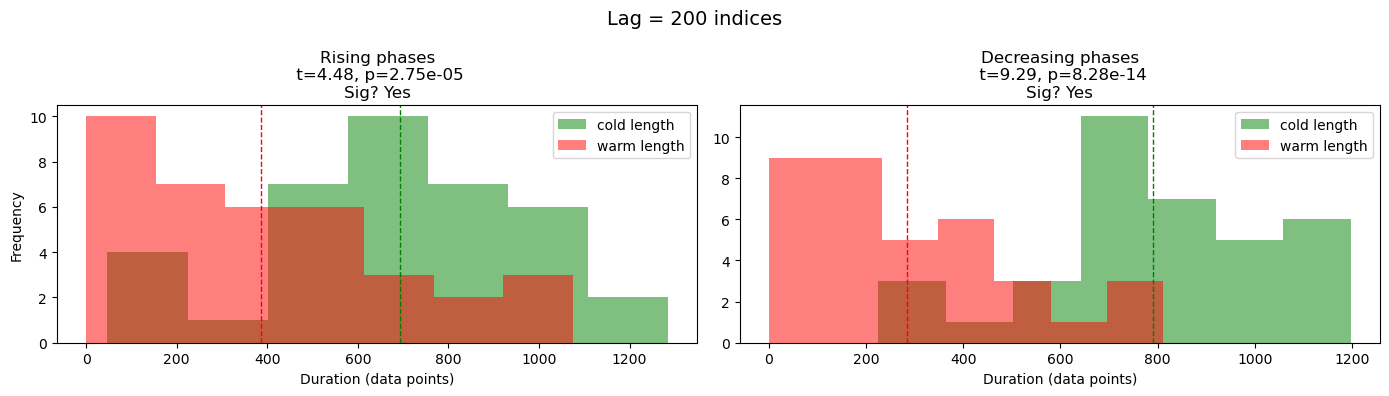

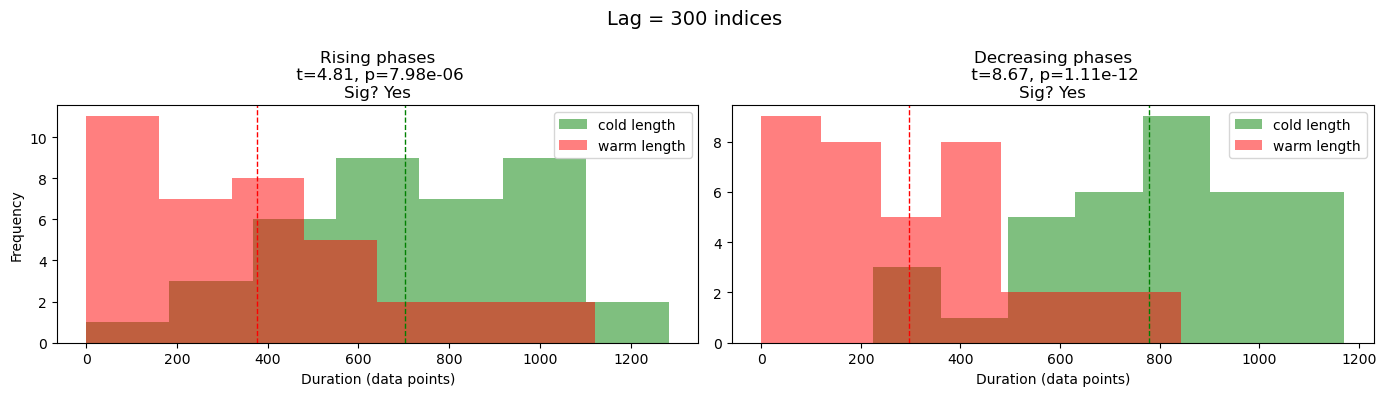

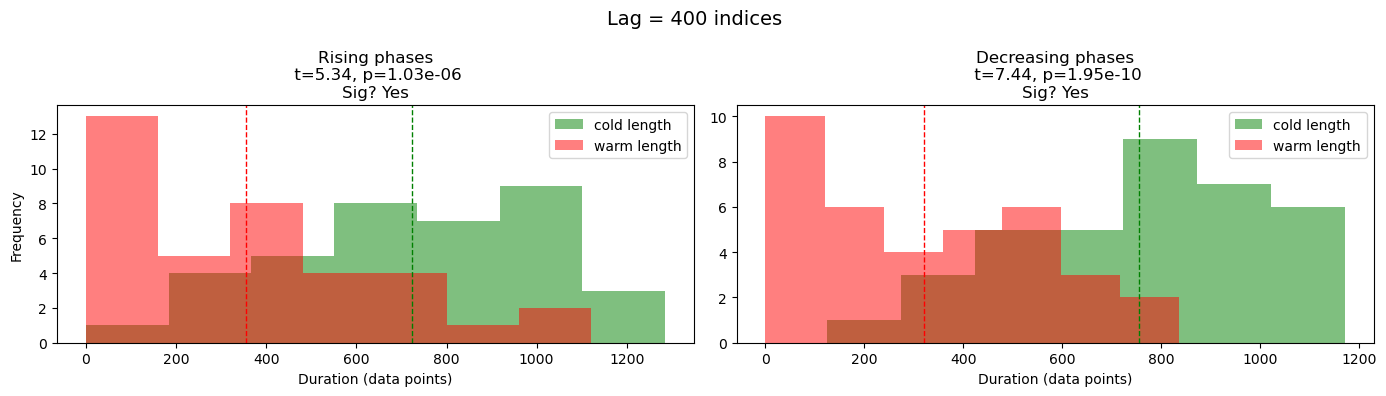

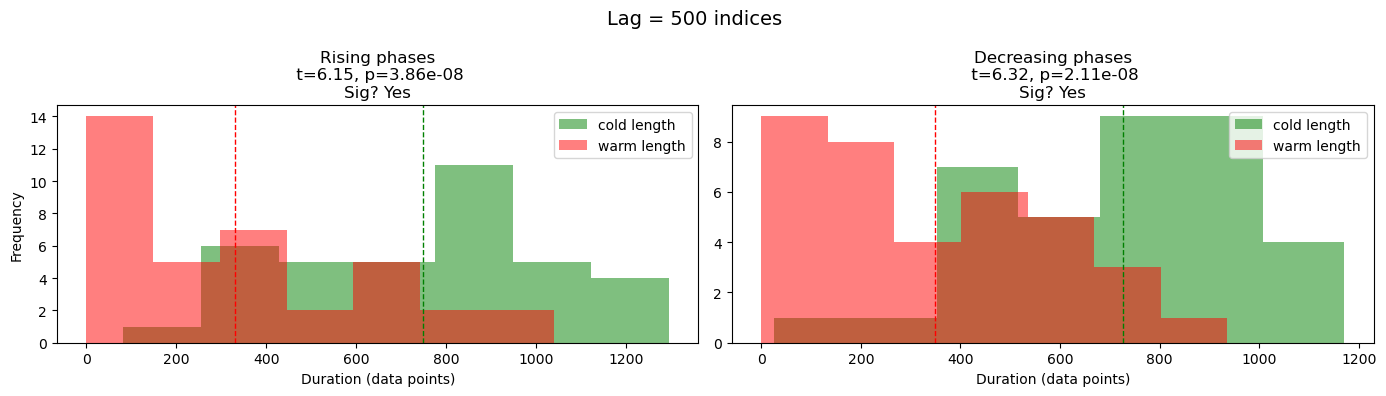

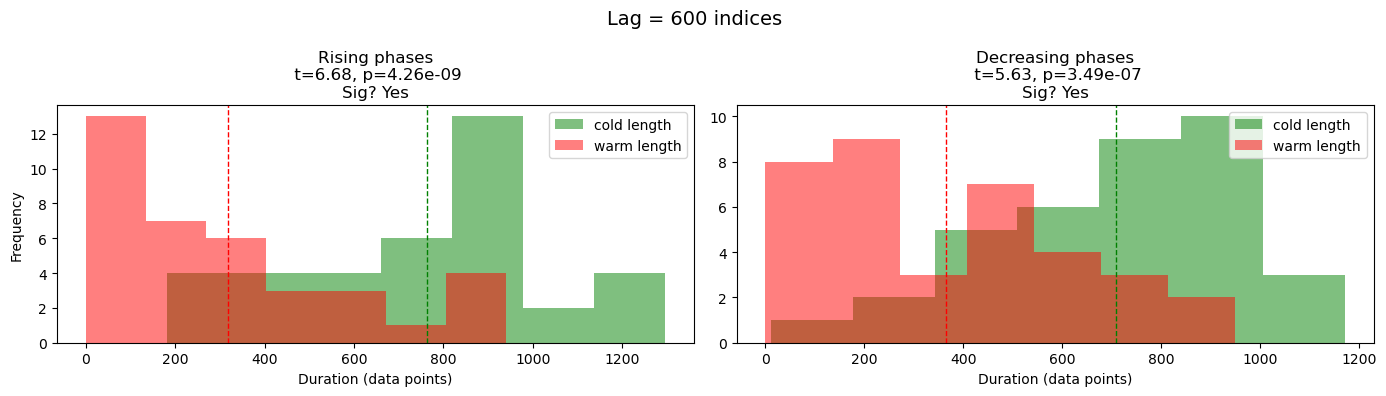

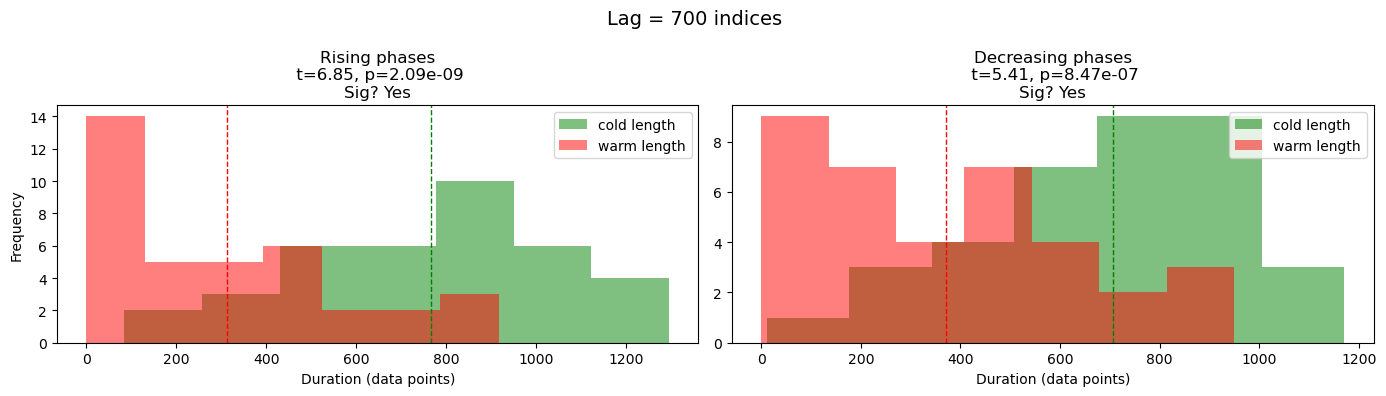

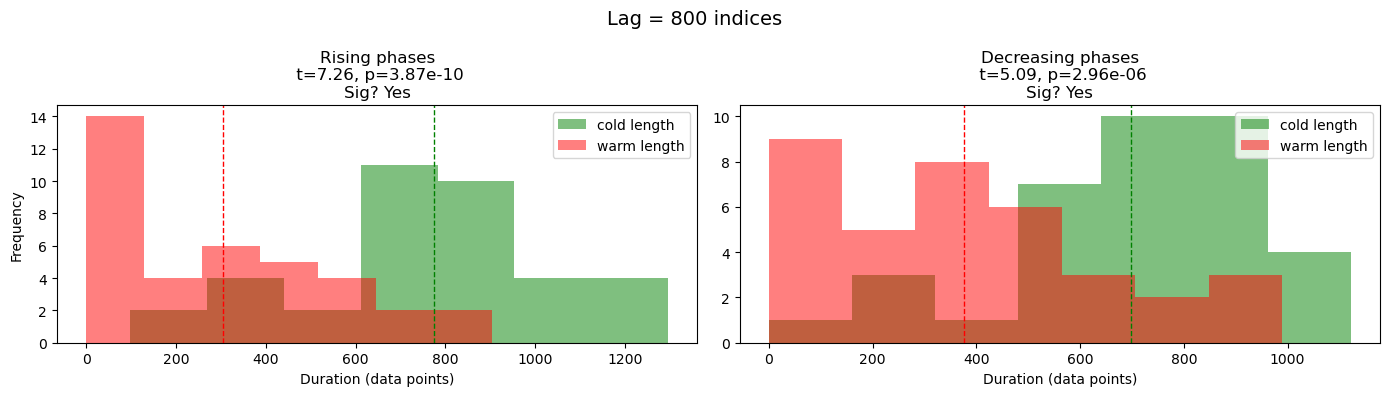

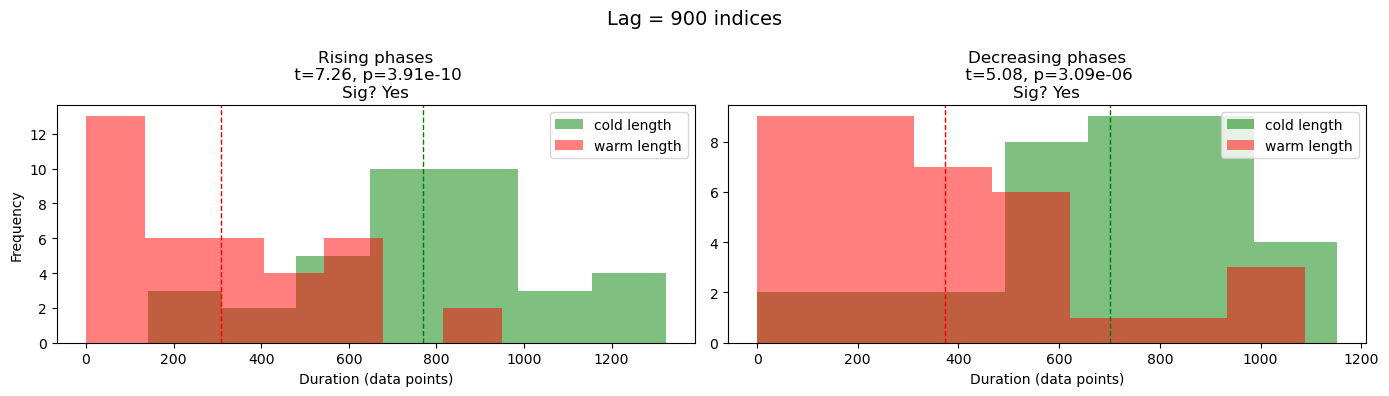

In [129]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_phase_durations(df_pre, df_sq)

→ optimal window=2110, threshold gt -2.962, max F1=0.631


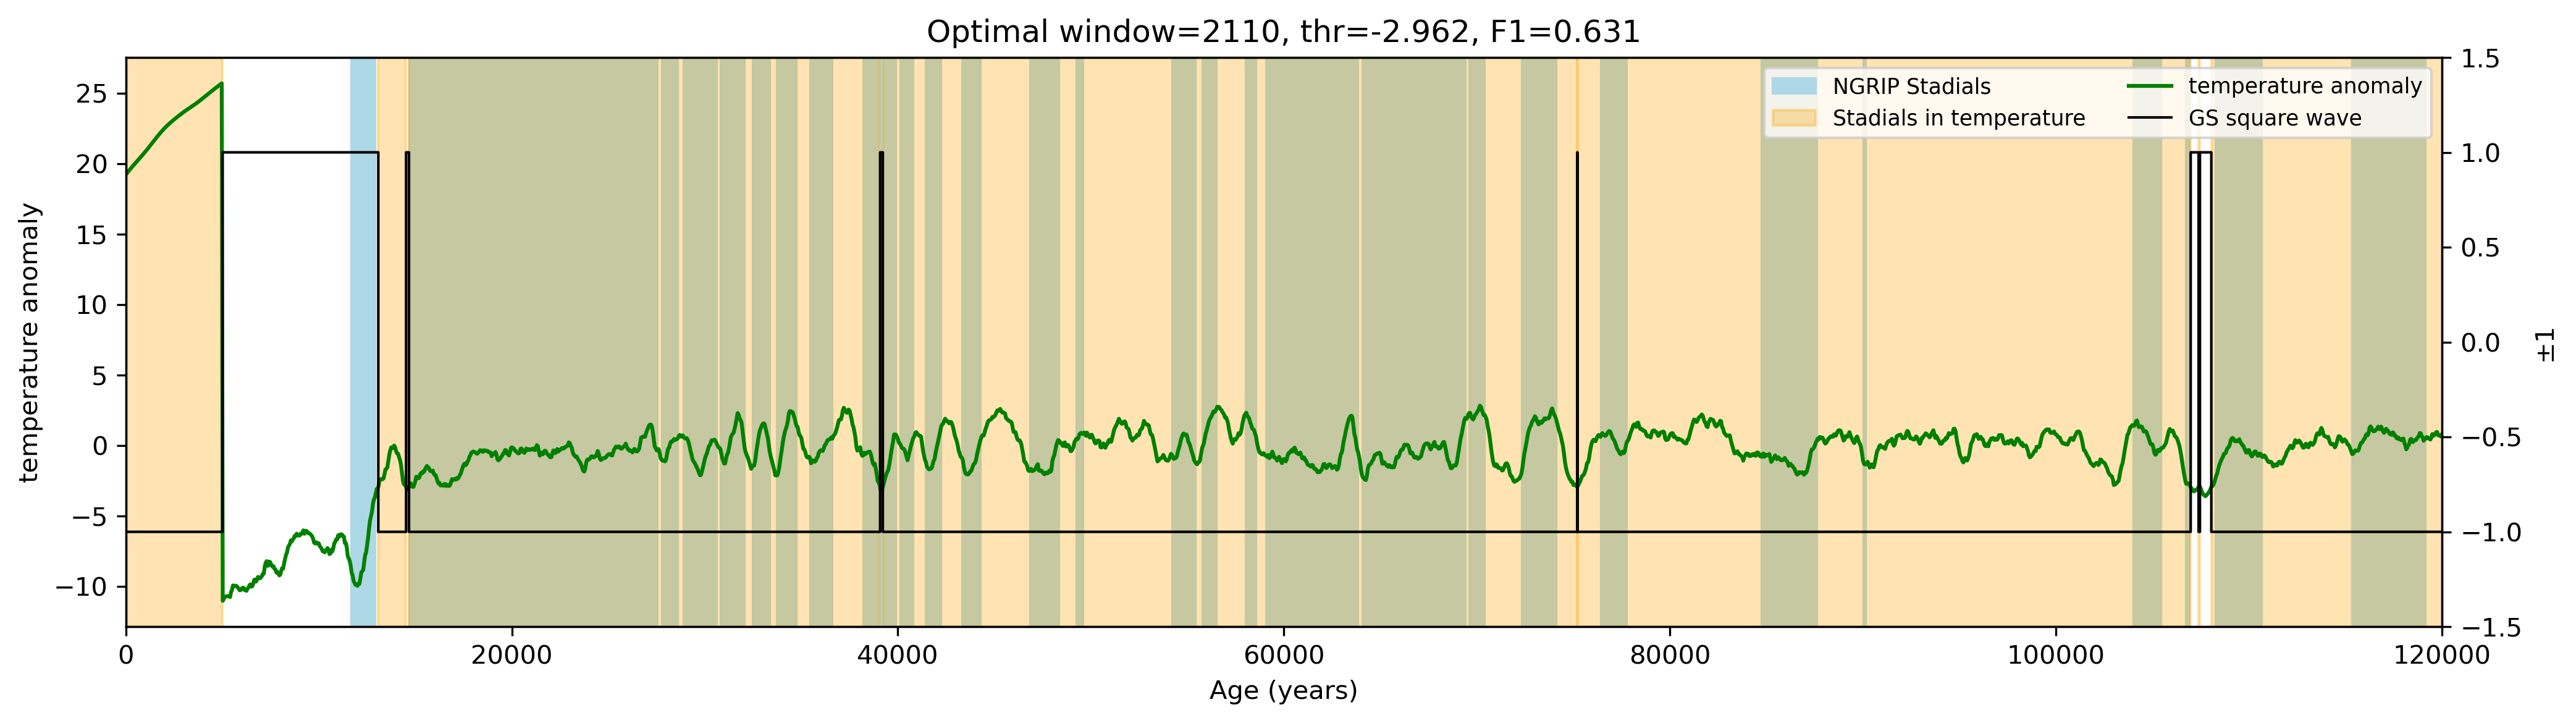

In [115]:

from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)
import pandas as pd

df = pd.read_csv('other_data/low_res_GT_syn_EDC_800kyr.csv')
df

new_df, df_sq, best = sa.build_DO_sq(df,  extra_sm=5, if_plot=True, dir='gt')